#***Step 1: Import Libraries***

---



We import the necessary libraries for data manipulation, visualization, and modeling.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error


#***Step 2: Load and Clean Data***

---



We load the data from a CSV file and drop unnecessary columns to clean the dataset.

In [7]:
# Load the dataset for a specific class  'micro')
data = pd.read_csv('modified_working_data.csv')
data.describe()


,Year,ServiceHeaderID,Amount,Month,Column1,LogAmount,frequency
count,122306.000000,1.223060e+05,122299.000000,122306.000000,0.0,122306.000000,122306.000000
mean,2020.133125,2.175250e+06,8476.197843,3.527595,NaN,8.920246,1.892170
std,16.423276,5.081029e+05,9256.027404,1.915989,NaN,16.281125,1.295895
min,2.000000,8.767600e+04,520.000000,1.000000,NaN,6.255750,1.000000
25%,2019.000000,1.923832e+06,4000.000000,2.000000,NaN,8.294300,1.000000
50%,2020.000000,2.307388e+06,6000.000000,3.000000,NaN,8.699681,1.000000
75%,2022.000000,2.509980e+06,8500.000000,4.000000,NaN,9.047939,2.000000
max,2023.000000,2.846320e+06,100000.000000,12.000000,NaN,2023.000000,9.047939


In [9]:
to_drop=['SubCounty','LogAmount','frequency','Year','PermitNo','ServiceHeaderID','pin','CustomerName','ServiceName','IssuedBy','BusinessActivity','Service Code','Ward','PhysicalLocation','DayOfWeek','Month','Column1']
data.drop(to_drop,inplace=True,axis=1)

In [10]:
# Display the first few rows of the cleaned data
data.head()


,class,DATE,Amount
0,micro,06/11/2023,4000.0
1,micro,03/11/2023,2000.0
2,micro,03/11/2023,4000.0
3,micro,02/11/2023,3400.0
4,micro,02/11/2023,3400.0


#***Step 3: Save Grouped Data to CSV Files***

We group the dataset by the "class" column and save each group to a separate CSV file.

In [11]:
# Group the dataset by the "class" column
grouped = data.groupby("class")

# Iterate over each group
for group_name, group_data in grouped:
    # Define the filename for this group
    filename = f"{group_name}.csv"

    # Save the group data to a CSV file
    group_data.to_csv(filename, index=False)


#***Step 4: Load Specific Class Data***

---



We load the dataset for a specific class 'micro' and drop the 'class' column

In [12]:
# Load the dataset for a specific class 'micro'
df = pd.read_csv('micro.csv')
df.describe()


,Amount
count,31378.000000
mean,3274.726560
std,799.540302
min,520.000000
25%,2800.000000
50%,3400.000000
75%,4000.000000
max,4000.000000


In [13]:
# Drop the 'class' column as it's no longer needed
df.drop(columns='class', inplace=True)


#***Step 5: Convert Date Column and Extract Features***

---



We convert the 'DATE' column to datetime format and extract year, month, and day as features.

In [14]:
# Convert the 'DATE' column to datetime format
df['DATE'] = pd.to_datetime(df['DATE'], dayfirst=True).dt.strftime('%m/%d/%Y')


In [15]:
# Prepare the data for XGBoost by extracting date features
df_xgb = df.reset_index()
df_xgb['DATE'] = pd.to_datetime(df_xgb['DATE'])
df_xgb['year'] = df_xgb['DATE'].dt.year
df_xgb['month'] = df_xgb['DATE'].dt.month
df_xgb['day'] = df_xgb['DATE'].dt.day
df_xgb.set_index('DATE', inplace=True)

#***Step 6: Define Features and Target***


---


We define the features and target variable for modeling.

In [16]:
# Define features and target variable
features = ['year', 'month', 'day']
target = 'Amount'
X = df_xgb[features]
y = df_xgb[target]

#***Step 7: Split Data into Training and Test Sets***

---



We split the data into training and test sets based on a specified split date.

In [17]:
# Split the data into training and test sets based on a split date
split_date = '2021-06-09'
X_train = X[X.index <= split_date]
X_test = X[X.index > split_date]
y_train = y[y.index <= split_date]
y_test = y[y.index > split_date]


#***Step 8: Train the XGBoost Model***

---



We train the XGBoost model on the training data.

In [18]:
# Train the XGBoost model on the training data
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

#***Step 9: Make Predictions***

---



We make predictions on the test data using the trained model.

In [20]:
# Make predictions on the test data
y_pred = xgb_model.predict(X_test)


#***Step 10: Evaluate the Model***

---



We define a function to calculate Mean Absolute Percentage Error (MAPE) and evaluate the model using RMSE, MAE, and MAPE.



In [21]:
# Define a function to calculate Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred):
    """Calculate MAPE given by y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


In [22]:
# Evaluate the model using RMSE, MAE, and MAPE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f'XGBoost RMSE: {rmse}')
print(f'XGBoost MAE: {mae}')
print(f'XGBoost MAPE: {mape}')

XGBoost RMSE: 780.7479055311212
XGBoost MAE: 654.598878165785
XGBoost MAPE: 23.137476638456715


#***Step 11: Plot Actual vs Predicted Values***

---



We plot the actual vs. predicted values to visualize the model's performance.

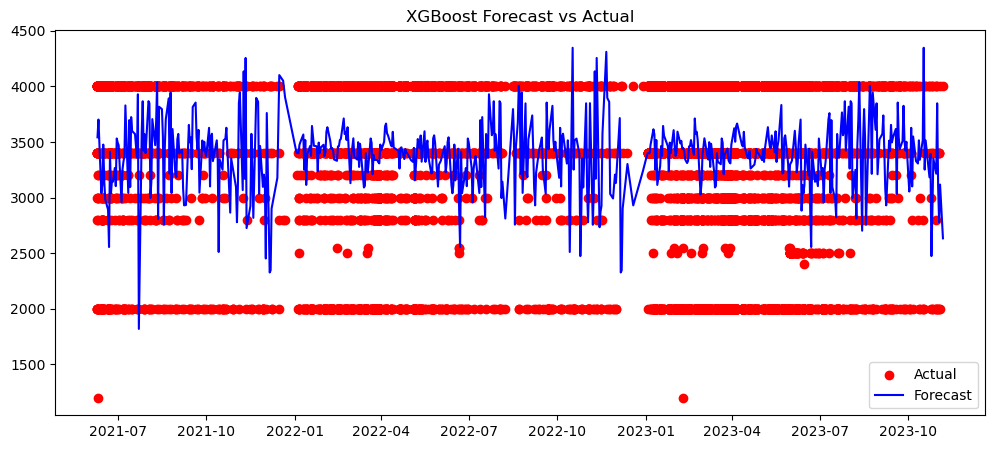

In [23]:
# Plot actual vs predicted values to visualize the model performance
fig, ax = plt.subplots(figsize=(12, 5))
ax.scatter(y_test.index, y_test, color='r', label='Actual')
ax.plot(y_test.index, y_pred, color='b', label='Forecast')
ax.set_title('XGBoost Forecast vs Actual')
ax.legend()
plt.show()


#***Step 12: Extend the Forecast for the Next 5 Years***

---



We extend the forecast for the next 5 years using the trained XGBoost model and plot the extended forecast.

In [24]:
# Extend the forecast for the next 5 years using XGBoost
future_dates = pd.date_range(start='2024-01-01', end='2028-12-31')
future_df = pd.DataFrame({'DATE': future_dates})
future_df['year'] = future_df['DATE'].dt.year
future_df['month'] = future_df['DATE'].dt.month
future_df['day'] = future_df['DATE'].dt.day

future_X = future_df[features]
future_predictions = xgb_model.predict(future_X)

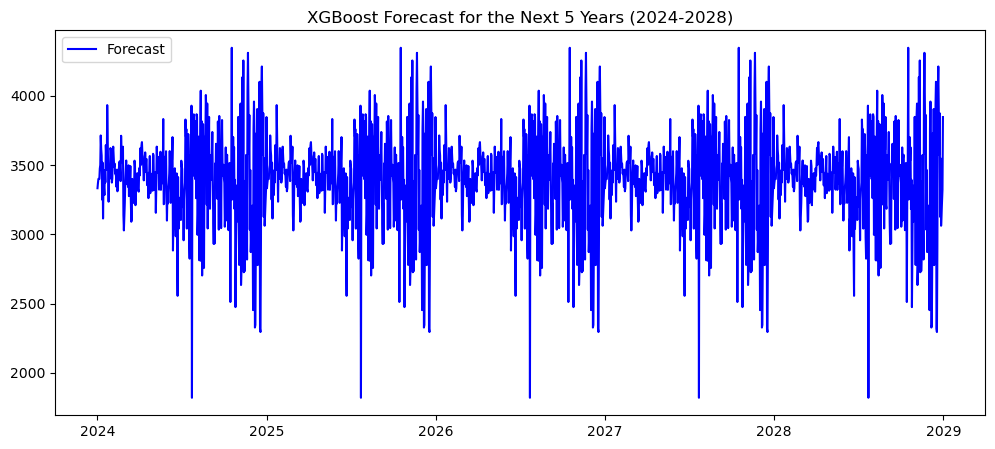

In [25]:
# Plot the extended forecast
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(future_dates, future_predictions, color='b', label='Forecast')
ax.set_title('XGBoost Forecast for the Next 5 Years (2024-2028)')
ax.legend()
plt.show()
